## 练习

1. 试着通过调整超参数来改善翻译效果。
1. 重新运行实验并在计算损失时不使用遮蔽，可以观察到什么结果？为什么会有这个结果？
1. 如果编码器和解码器的层数或者隐藏单元数不同，那么如何初始化解码器的隐状态？
1. 在训练中，如果用前一时间步的预测输入到解码器来代替强制教学，对性能有何影响？
1. 用长短期记忆网络替换门控循环单元重新运行实验。
1. 有没有其他方法来设计解码器的输出层？

loss 0.062, 14871.9 tokens/sec on cuda:0
go . => <unk> <unk> !, bleu 0.000
i lost . => je suis malade ?, bleu 0.000
he's calm . => il est paresseux ., bleu 0.658
i'm home . => je suis malade ., bleu 0.512


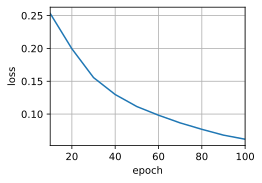

In [8]:
## 练习1
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l
import os

# 自定义读取数据的函数
def read_data_nmt():
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()

# 数据预处理
def preprocess_nmt(text):
    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and char in set(',.!?') and text[i - 1] != ' ' else char
           for i, char in enumerate(text)]
    return ''.join(out)

# 分词
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

# 自定义加载数据函数
def load_data_nmt(batch_size, num_steps, num_examples=600):
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

# 将文本序列转换成小批量
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

# 截断或填充文本序列
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    return line[:num_steps] if len(line) > num_steps else line + [padding_token] * (num_steps - len(line))

class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()	# 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

# 设置超参数
embed_size, num_hiddens, num_layers, dropout = 64, 64, 4, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.001, 100, d2l.try_gpu()

# 加载数据集
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

# 定义模型
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

# 训练模型
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

# 测试模型
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, _ = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

Epoch 10, Loss: 0.240
Epoch 20, Loss: 0.189
Epoch 30, Loss: 0.160
Epoch 40, Loss: 0.140
Epoch 50, Loss: 0.124
Epoch 60, Loss: 0.111
Epoch 70, Loss: 0.099
Epoch 80, Loss: 0.088
Epoch 90, Loss: 0.079
Epoch 100, Loss: 0.072


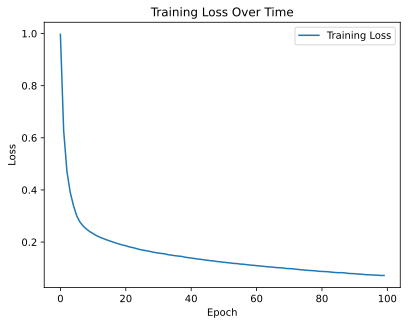

In [17]:
## 练习2
import matplotlib.pyplot as plt

class UnmaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """不带遮蔽的softmax交叉熵损失函数"""
    def forward(self, pred, label):
        self.reduction = 'none'
        unweighted_loss = super(UnmaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        return unweighted_loss.mean(dim=1)

def xavier_init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
    
def train_seq2seq_unmasked(net, data_iter, lr, num_epochs, device):
    """训练序列到序列模型（不使用遮蔽）"""
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = UnmaskedSoftmaxCELoss()
    net.train()
    loss_values = []  # 用于存储每个时期的平均损失

    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y)  # 不使用valid_len
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        avg_loss = metric[0] / metric[1]
        loss_values.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Loss: {avg_loss:.3f}')

    return loss_values

# 训练模型（不使用遮蔽）
loss_values = train_seq2seq_unmasked(net, train_iter, lr, num_epochs, device)
# 绘制损失曲线
plt.plot(loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

## 练习3
在标准的序列到序列模型中，编码器的最终隐状态常常用来初始化解码器的隐状态。但是，当编码器和解码器的层数或隐藏单元数不同时，这种直接传递就不再可行，因为它们的隐状态维度不匹配。

针对这种情况，有几种可能的解决方法：

1. **变换层**: 引入一个额外的线性变换层（或多个层），将编码器的最终隐状态转换为与解码器兼容的形式。这个线性变换可以是一个简单的全连接层，它的输出维度与解码器的隐状态维度匹配。

2. **汇总编码器状态**: 如果编码器有多层，可以将这些层的隐状态进行汇总（例如，通过取平均或使用一个额外的全连接层）来产生一个单一的隐状态，然后将这个状态用作解码器的初始状态。

3. **单独初始化**: 直接为解码器单独初始化一个隐状态，而不是从编码器传递。这个初始化可以是固定的（如零初始化），或者是基于输入数据的某种函数。

4. **使用注意力机制**: 在解码过程中，使用注意力机制直接根据编码器的输出和解码器的当前状态动态计算上下文信息，而不是依赖于静态的初始隐状态。这种方法在许多先进的序列到序列模型中被广泛使用。


## 练习4
在序列到序列模型的训练中，通常使用的是强制教学（teacher forcing）技术。在强制教学中，解码器在每个时间步都使用真实的前一个词元作为输入，而不是使用模型的预测输出。这种方法可以加速训练并提高模型的稳定性。但它也可能导致训练和推理（测试）阶段的不一致，这被称为"暴露偏差"（exposure bias）问题。

如果在训练过程中改用前一时间步的预测输出作为解码器的输入，可能会有以下影响：

1. **性能下降**：由于模型刚开始训练时预测的准确性较低，这可能导致错误的预测在后续步骤中累积，降低整体性能。

2. **训练难度提高**：不使用强制教学会增加训练难度，因为模型需要从自己的错误中学习，而这些错误可能会在序列中传播。

3. **缓解暴露偏差**：这种方法可以使训练过程更接近实际推理过程，从而可能有助于减轻训练和推理阶段的不一致问题。

4. **可能需要更多的训练时间**：由于训练过程更加困难，可能需要更多的时间来达到相似的性能水平。

为了实现这种训练策略，您需要修改训练循环，使其在每个时间步使用模型的预测输出作为下一个输入，而不是使用真实标签。

loss 0.020, 15787.7 tokens/sec on cuda:0


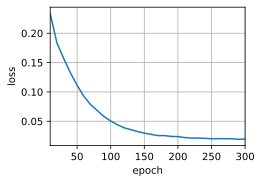

In [23]:
## 练习5
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的LSTM编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super(Seq2SeqEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)  # RNN需要时间步在前的格式
        output, state = self.rnn(X)
        return output, state

class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的LSTM解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super(Seq2SeqDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]  # 返回LSTM的隐状态和细胞状态

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        context = state[0][-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        return output, state

# 设置超参数
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

# 加载数据集
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

# 定义模型
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

# 训练模型
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 练习6
在序列到序列（Seq2Seq）模型中，解码器的输出层通常是一个全连接层（或线性层），它将循环神经网络的隐藏状态转换为输出序列中的词元概率。尽管这是一种常见且有效的设计，但确实存在其他方法来设计解码器的输出层。以下是一些可行的替代方案：

1. **使用多个全连接层**：可以通过增加额外的全连接层（可能包括非线性激活函数）来创建更复杂的输出结构。这可以帮助模型学习更复杂的映射，但可能需要更多的数据来有效地训练。

2. **引入注意力机制**：注意力机制可以被用来动态地选择编码器输出的相关部分，以辅助解码过程。这在处理长序列时特别有效，因为它允许模型聚焦于当前步骤最相关的输入部分。

3. **使用卷积层**：虽然不太常见，但在某些情况下，卷积层可以被用于解码器的输出层，特别是当输出序列具有某种空间或时间结构时。

4. **结合循环网络和卷积网络**：在某些情况下，结合使用循环网络和卷积网络可以提高性能。例如，卷积层可以用来捕获局部上下文，而循环网络则处理长期依赖。

5. **输出层正则化**：在输出层增加正则化项（例如Dropout或Batch Normalization）可以帮助防止过拟合，并有助于模型泛化。
